In [1]:
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.set_device(0)

In [25]:
PATH = "../../storage/ferriswheel/"
sz = 224
arch = resnet34
bs = 58

In [26]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(path=PATH, bs=bs, tfms=tfms, trn_name='train', val_name='valid',
                                     test_name='test_images')

In [27]:
fn = PATH + data.trn_ds.fnames[0]
fn

'../../storage/ferriswheel/train/bags/pic_088.jpg'

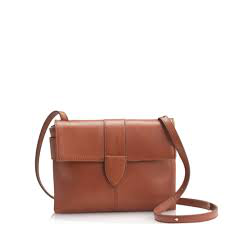

In [28]:
img = PIL.Image.open(fn)
img

In [29]:
img.size

(225, 225)

In [30]:
sizes = {k : PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}
row_sizes, col_sizes = list(zip(*sizes.values()))
row_sizes = np.array(row_sizes)
col_sizes = np.array(col_sizes)

(array([  9.,   1., 184., 800.,  64.,  77.,   7.,   3.,   0.,   1.]),
 array([ 78., 117., 156., 195., 234., 273., 312., 351., 390., 429., 468.]),
 <a list of 10 Patch objects>)

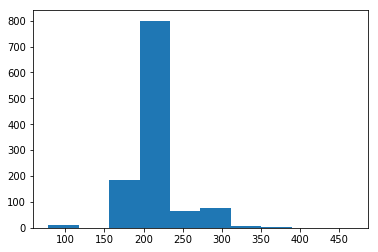

In [31]:
plt.hist(row_sizes)

(array([  1.,   3.,  37.,  63.,  55., 685., 100.,  98.,  94.,  10.]),
 array([108. , 128.7, 149.4, 170.1, 190.8, 211.5, 232.2, 252.9, 273.6, 294.3, 315. ]),
 <a list of 10 Patch objects>)

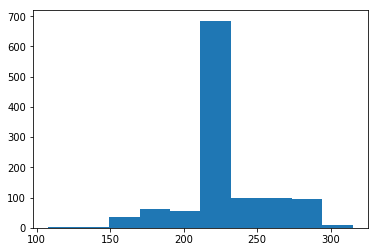

In [32]:
plt.hist(col_sizes)

In [33]:
len(data.trn_ds), len(data.test_ds)

(1146, 972)

In [34]:
data.classes

['bags',
 'dress',
 'intimates',
 'jeans',
 'jewelry',
 'shoes',
 'skirts',
 'swimwear',
 'tops']

In [42]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_paths(path=PATH, bs=bs, tfms=tfms, trn_name='train', val_name='valid',
                                          test_name='test_images')
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time

In [45]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(.01, 5)

100%|██████████| 17/17 [00:10<00:00,  1.56it/s]


epoch      trn_loss   val_loss   accuracy                 
    0      1.587995   0.646272   0.786213  
    1      1.046916   0.457504   0.858639                
    2      0.825716   0.377711   0.883944                  
    3      0.697478   0.312936   0.895288                 
    4      0.598289   0.302437   0.911867                 


[array([0.30244]), 0.9118673704681596]

In [46]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=.5)
learn.fit(.01, 2)

epoch      trn_loss   val_loss   accuracy                 
    0      1.749116   0.733736   0.765271  
    1      1.218164   0.495948   0.844677                 


[array([0.49595]), 0.844677142239782]

In [47]:
learn.precompute = False
learn.fit(.01, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.727152   0.461084   0.848168  
    1      0.70616    0.435978   0.860384                  
    2      0.697634   0.409975   0.862129                  
    3      0.674445   0.393746   0.876091                  
    4      0.653511   0.383537   0.875218                  


[array([0.38354]), 0.8752181512315028]

In [48]:
learn.save('224_pre')
learn.load('224_pre')

In [49]:
learn.set_data(get_data(299, bs))
learn.freeze()
learn.fit(.01, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.629482   0.414351   0.867365  
    1      0.635756   0.39437    0.871728                  
    2      0.620815   0.379104   0.876963                  


[array([0.3791]), 0.8769633501612079]

In [51]:
learn.fit(.01, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.596842   0.372625   0.877836  
    1      0.573327   0.357002   0.881326                  
    2      0.549961   0.353205   0.884817                  
    3      0.560369   0.33509    0.891798                  
    4      0.544371   0.325036   0.897033                  
    5      0.535829   0.319676   0.896161                  
    6      0.528016   0.317382   0.896161                  


[array([0.31738]), 0.8961605648095695]

In [55]:
log_preds, y = learn.TTA()
log_preds.shape, y.shape

((5, 1146, 9), (1146,))

In [56]:
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9031413612565445, 0.3194383113577649)

In [57]:
log_preds, y = learn.TTA(is_test=True)
log_preds.shape, y.shape

((5, 968, 9), (968, 1))

In [58]:
test_probs = np.mean(np.exp(log_preds), 0)

In [62]:
df = pd.DataFrame(test_probs)
df.columns = data.classes
df.insert(0, 'id', [test_name[12:] for test_name in data.test_ds.fnames])

In [63]:
df.head()

,id,bags,dress,intimates,jeans,jewelry,shoes,skirts,swimwear,tops
0,image_725.jpg,0.007655,0.134148,0.067269,0.150046,0.001597,0.005389,0.486608,0.015522,0.131764
1,image_358.jpg,0.011296,0.012045,0.005714,0.928113,0.000826,0.001432,0.015479,0.003868,0.021227
2,image_63.jpg,0.046953,0.063078,0.007569,0.726309,0.001360,0.004923,0.135045,0.002710,0.012055
3,image_171.jpg,0.001024,0.886496,0.005560,0.003515,0.000076,0.000128,0.089454,0.003778,0.009970
4,image_386.jpg,0.003457,0.033409,0.009294,0.028560,0.000267,0.000049,0.088375,0.018648,0.817940


In [96]:
import json
data_with_labels = []
trn_tfms, val_tfms = tfms_from_model(arch, sz)
with open('../../storage/product-classification-challenge-master/product_data.json') as f:
    data = json.load(f)
    for img_number, img_data in enumerate(data):
        try:
            im = val_tfms(open_image(PATH + 'test_images/image_{}.jpg'.format(img_number)))
            preds = learn.predict_array(im[None])
            probs = list(np.exp(preds)[0])
            top_two_indices = [probs.index(x) for x in sorted(probs, reverse=True)[:2]]
            top_id = top_two_indices[0]
            second_id = top_two_indices[1]
            prediction = '{} : {:.2f}, {} : {:.2f}'.format(learn.data.classes[top_id], probs[top_id], 
                                                           learn.data.classes[second_id], probs[second_id])
            img_data['prediction'] = prediction
            data_with_labels.append(img_data)
        except IOError as err:
            img_data['prediction'] = 'unknown'
            data_with_labels.append(img_data)
        #print(img_data)
        
with open('../../storage/product-classification-challenge-master/product_data_categorized.json', 'w') as f:
    json.dump(data_with_labels, f)
    